# CNN + MaxPool
Print confusion matrices.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-20 22:37:17.678378


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
CFILTERS=128 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
MINLEN=200
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_LINES = 15   # 15 to analyze all of them
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = np.power(values,2)
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = 0.0
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN \
                    and gene_id in self.gene2rci.keys():
                        allids.append( (gene_id,tran_id) )
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    cnn3_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    cnn4_layer = Conv1D(CFILTERS//2, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    #drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool1_layer)
    cnn.add(cnn3_layer)
    cnn.add(cnn4_layer)
    cnn.add(pool2_layer)
    cnn.add(flat_layer)
    #cnn.add(dens_layer)
    #cnn.add(drop_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-20 22:37:50.310571
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4997, 4)           1028      
                                                                 
 conv1d (Conv1D)             (None, 4990, 128)         4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 4983, 128)         131200    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1244, 128)        0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 1237, 64)          65600     
                                                                 
 conv1d_3 (Conv1D)           (None, 1230, 64)          32832     
                             

## Training

In [12]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # validation_data=(X_valid,y_valid) ) 
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [13]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-20 22:41:09.427845
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4236 sequences.
2023-03-20 22:41:20.696610

Training # 1 1
2023-03-20 22:41:20.697260
2023-03-20 22:41:20.697325
Discriminator ZERO -1
FIT
2023-03-20 22:41:21.897152


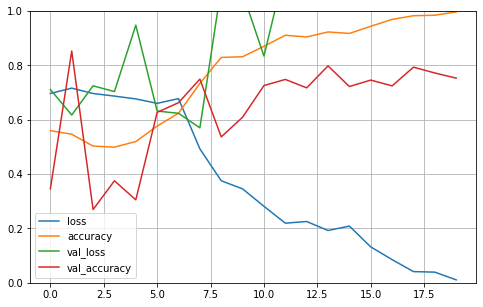


2023-03-20 22:43:25.647810

Testing # 1 1
2023-03-20 22:43:25.648237
2023-03-20 22:43:25.648273
PREDICT
2023-03-20 22:43:25.875402
Test 1:0 718:124 85.27%
Predict 1:0 722:120 85.75%
Test sizes (842, 4997) (842,)
Range of scores: 5.4637765e-09 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 18 106]
 [102 616]]
Normalized matrix
 [[0.02137767 0.12589074]
 [0.12114014 0.73159145]]


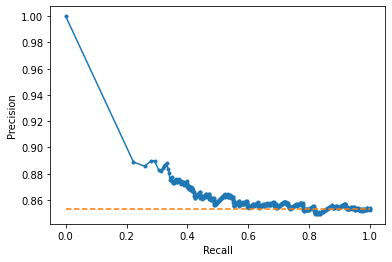

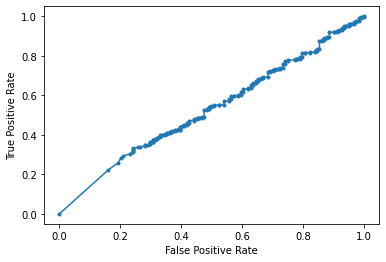

Accuracy: 75.30% Precision: 85.32% Recall: 85.79%
F1: 85.56% MCC: 0.0031
AUPRC: 88.09% AUROC: 53.00%
 accuracy [75.29691211401425]
 precision [85.3185595567867]
 recall [85.79387186629526]
 F1 [85.55555555555556]
 MCC [0.0031425109203728854]
 AUPRC [88.09292680579283]
 AUROC [53.00004492766646]
2023-03-20 22:43:26.827863

Training # 1 2
2023-03-20 22:43:26.828545
2023-03-20 22:43:26.828588
Discriminator ZERO -1
FIT
2023-03-20 22:43:28.044798


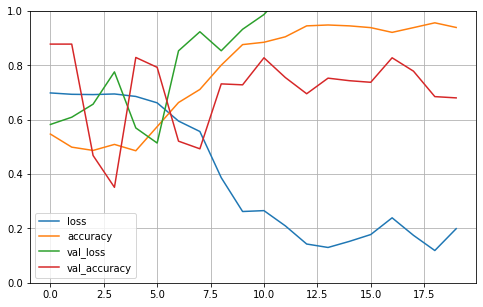


2023-03-20 22:45:51.511473

Testing # 1 2
2023-03-20 22:45:51.511574
2023-03-20 22:45:51.511610
PREDICT
2023-03-20 22:45:51.733988
Test 1:0 750:104 87.82%
Predict 1:0 645:209 75.53%
Test sizes (854, 4997) (854,)
Range of scores: 8.359745e-12 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 20  84]
 [189 561]]
Normalized matrix
 [[0.0234192  0.09836066]
 [0.22131148 0.65690867]]


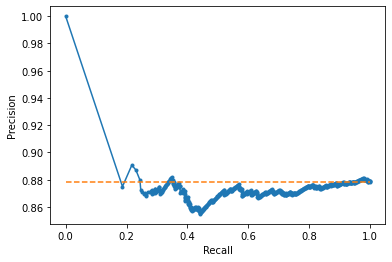

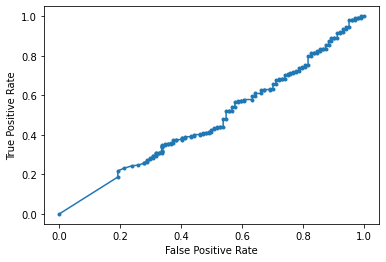

Accuracy: 68.03% Precision: 86.98% Recall: 74.80%
F1: 80.43% MCC: -0.0454
AUPRC: 88.47% AUROC: 47.56%
 accuracy [68.0327868852459]
 precision [86.9767441860465]
 recall [74.8]
 F1 [80.43010752688173]
 MCC [-0.04540593989483809]
 AUPRC [88.4742079429877]
 AUROC [47.55897435897436]
2023-03-20 22:45:53.143547

Training # 1 3
2023-03-20 22:45:53.143749
2023-03-20 22:45:53.143799
Discriminator ZERO -1
FIT
2023-03-20 22:45:54.347499


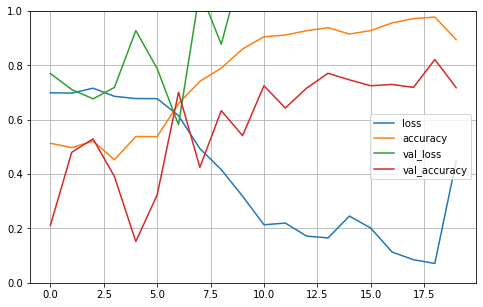


2023-03-20 22:48:18.261763

Testing # 1 3
2023-03-20 22:48:18.262086
2023-03-20 22:48:18.262133
PREDICT
2023-03-20 22:48:18.486560
Test 1:0 704:125 84.92%
Predict 1:0 660:169 79.61%
Test sizes (829, 4997) (829,)
Range of scores: 1.28741705e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 30  95]
 [139 565]]
Normalized matrix
 [[0.03618818 0.1145959 ]
 [0.16767189 0.68154403]]


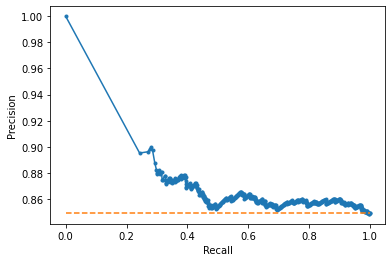

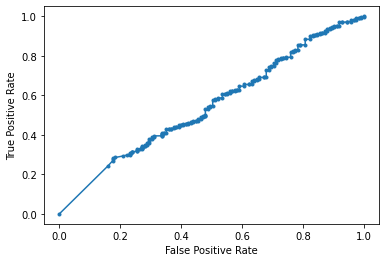

Accuracy: 71.77% Precision: 85.61% Recall: 80.26%
F1: 82.84% MCC: 0.0378
AUPRC: 88.39% AUROC: 55.00%
 accuracy [71.77322074788903]
 precision [85.60606060606061]
 recall [80.25568181818183]
 F1 [82.84457478005865]
 MCC [0.037800292974041055]
 AUPRC [88.38982150437059]
 AUROC [55.00454545454545]
2023-03-20 22:48:19.922741

Training # 1 4
2023-03-20 22:48:19.922961
2023-03-20 22:48:19.923013
Discriminator ZERO -1
FIT
2023-03-20 22:48:22.062927


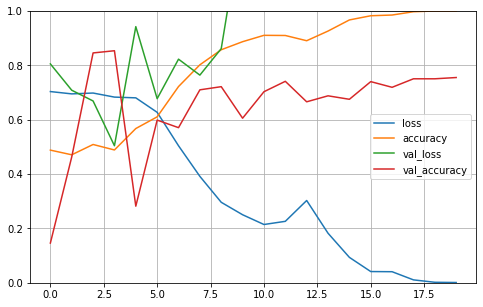


2023-03-20 22:50:23.556772

Testing # 1 4
2023-03-20 22:50:23.557199
2023-03-20 22:50:23.557240
PREDICT
2023-03-20 22:50:23.797423
Test 1:0 736:126 85.38%
Predict 1:0 763:99 88.52%
Test sizes (862, 4997) (862,)
Range of scores: 7.027551e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[  7 119]
 [ 92 644]]
Normalized matrix
 [[0.00812065 0.13805104]
 [0.10672854 0.74709977]]


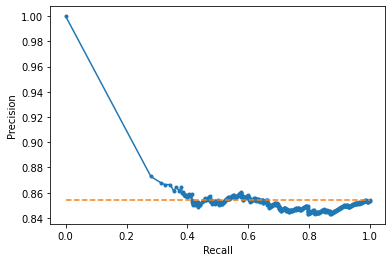

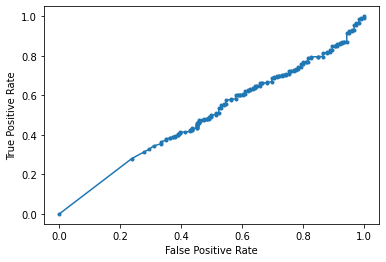

Accuracy: 75.52% Precision: 84.40% Recall: 87.50%
F1: 85.92% MCC: -0.0769
AUPRC: 87.65% AUROC: 49.72%
 accuracy [75.52204176334106]
 precision [84.40366972477065]
 recall [87.5]
 F1 [85.92394929953302]
 MCC [-0.07694525111926755]
 AUPRC [87.65276551846387]
 AUROC [49.720712560386474]
2023-03-20 22:50:25.017071

Training # 1 5
2023-03-20 22:50:25.017244
2023-03-20 22:50:25.019054
Discriminator ZERO -1
FIT
2023-03-20 22:50:26.209761


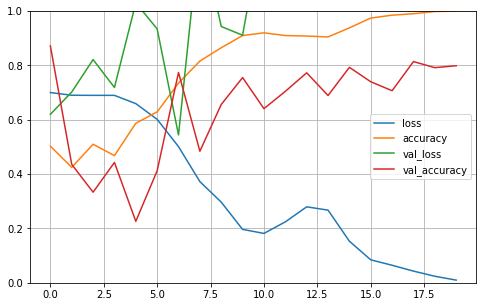


2023-03-20 22:52:49.596436

Testing # 1 5
2023-03-20 22:52:49.596549
2023-03-20 22:52:49.596587
PREDICT
2023-03-20 22:52:49.818692
Test 1:0 740:109 87.16%
Predict 1:0 773:76 91.05%
Test sizes (849, 4997) (849,)
Range of scores: 4.612229e-05 to 1.0
Score threshold 0.5
Confusion matrix
 [[  7 102]
 [ 69 671]]
Normalized matrix
 [[0.00824499 0.12014134]
 [0.08127208 0.79034158]]


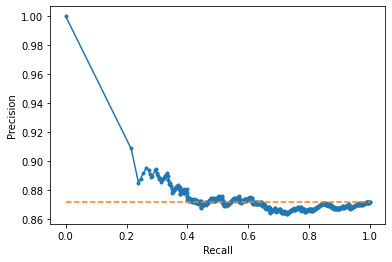

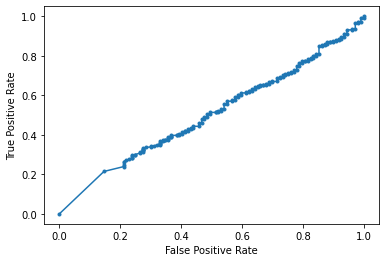

Accuracy: 79.86% Precision: 86.80% Recall: 90.68%
F1: 88.70% MCC: -0.0340
AUPRC: 89.11% AUROC: 50.56%
 accuracy [79.85865724381625]
 precision [86.80465717981889]
 recall [90.67567567567568]
 F1 [88.69795109054857]
 MCC [-0.03400758261441956]
 AUPRC [89.11146946399906]
 AUROC [50.560376890652115]
2023-03-20 22:52:51.691955

Training # 2 1
2023-03-20 22:52:51.693689
2023-03-20 22:52:51.693746
Discriminator ZERO -1
FIT
2023-03-20 22:52:52.880229


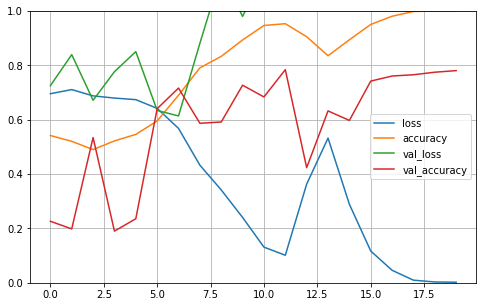


2023-03-20 22:55:16.353074

Testing # 2 1
2023-03-20 22:55:16.353185
2023-03-20 22:55:16.353253
PREDICT
2023-03-20 22:55:16.576853
Test 1:0 735:122 85.76%
Predict 1:0 761:96 88.80%
Test sizes (857, 4997) (857,)
Range of scores: 1.7170132e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 15 107]
 [ 81 654]]
Normalized matrix
 [[0.01750292 0.12485414]
 [0.09451575 0.76312719]]


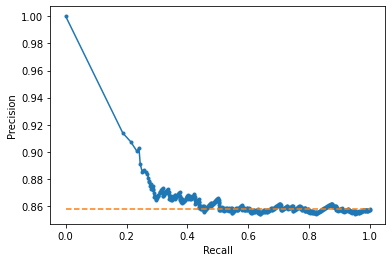

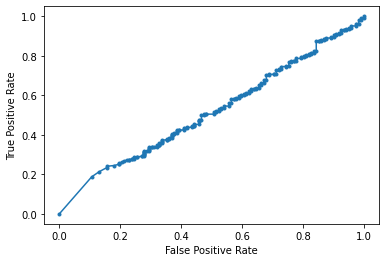

Accuracy: 78.06% Precision: 85.94% Recall: 88.98%
F1: 87.43% MCC: 0.0141
AUPRC: 88.17% AUROC: 51.89%
 accuracy [78.0630105017503]
 precision [85.9395532194481]
 recall [88.9795918367347]
 F1 [87.43315508021391]
 MCC [0.014121951011502248]
 AUPRC [88.16776430509464]
 AUROC [51.88580350172855]
2023-03-20 22:55:18.140785

Training # 2 2
2023-03-20 22:55:18.140980
2023-03-20 22:55:18.141029
Discriminator ZERO -1
FIT
2023-03-20 22:55:19.318226


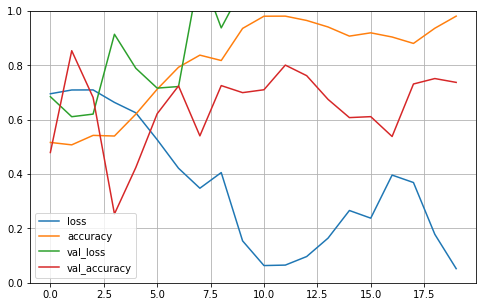


2023-03-20 22:57:42.939281

Testing # 2 2
2023-03-20 22:57:42.939387
2023-03-20 22:57:42.939426
PREDICT
2023-03-20 22:57:43.170593
Test 1:0 725:124 85.39%
Predict 1:0 722:127 85.04%
Test sizes (849, 4997) (849,)
Range of scores: 5.4718962e-11 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 14 110]
 [113 612]]
Normalized matrix
 [[0.01648999 0.12956419]
 [0.13309776 0.72084806]]


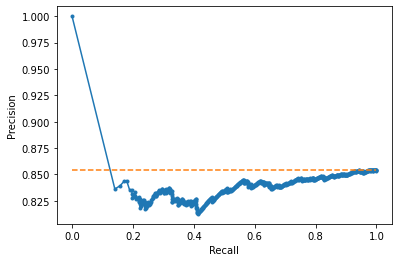

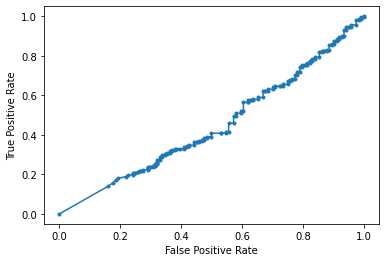

Accuracy: 73.73% Precision: 84.76% Recall: 84.41%
F1: 84.59% MCC: -0.0425
AUPRC: 84.92% AUROC: 44.82%
 accuracy [73.73380447585394]
 precision [84.7645429362881]
 recall [84.41379310344827]
 F1 [84.58880442294404]
 MCC [-0.042536520765608175]
 AUPRC [84.92081820397898]
 AUROC [44.820912124582875]
2023-03-20 22:57:44.407901

Training # 2 3
2023-03-20 22:57:44.408090
2023-03-20 22:57:44.408140
Discriminator ZERO -1
FIT
2023-03-20 22:57:46.531125


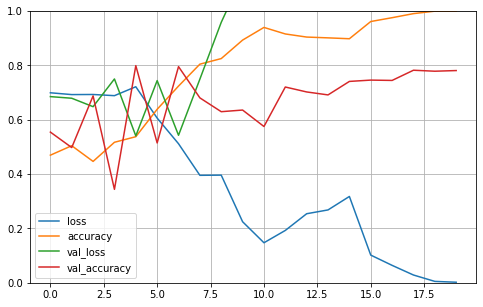


2023-03-20 22:59:49.614677

Testing # 2 3
2023-03-20 22:59:49.614777
2023-03-20 22:59:49.614815
PREDICT
2023-03-20 22:59:49.820982
Test 1:0 711:115 86.08%
Predict 1:0 740:86 89.59%
Test sizes (826, 4997) (826,)
Range of scores: 2.356273e-10 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 10 105]
 [ 76 635]]
Normalized matrix
 [[0.01210654 0.12711864]
 [0.09200969 0.76876513]]


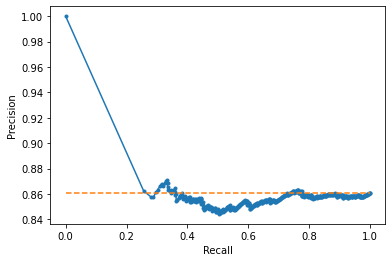

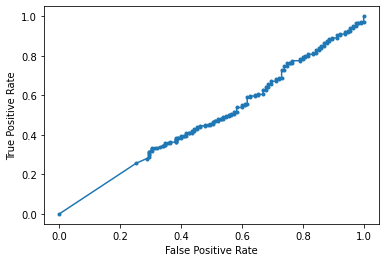

Accuracy: 78.09% Precision: 85.81% Recall: 89.31%
F1: 87.53% MCC: -0.0226
AUPRC: 87.56% AUROC: 48.41%
 accuracy [78.08716707021792]
 precision [85.8108108108108]
 recall [89.31082981715893]
 F1 [87.52584424534804]
 MCC [-0.02259637629456575]
 AUPRC [87.56245986810805]
 AUROC [48.40946615299945]
2023-03-20 22:59:51.017453

Training # 2 4
2023-03-20 22:59:51.018755
2023-03-20 22:59:51.018812
Discriminator ZERO -1
FIT
2023-03-20 22:59:52.226897


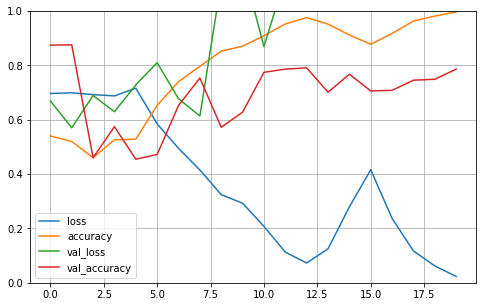


2023-03-20 23:02:15.655810

Testing # 2 4
2023-03-20 23:02:15.655903
2023-03-20 23:02:15.655937
PREDICT
2023-03-20 23:02:15.874028
Test 1:0 753:107 87.56%
Predict 1:0 753:107 87.56%
Test sizes (860, 4997) (860,)
Range of scores: 3.5655017e-08 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 15  92]
 [ 92 661]]
Normalized matrix
 [[0.01744186 0.10697674]
 [0.10697674 0.76860465]]


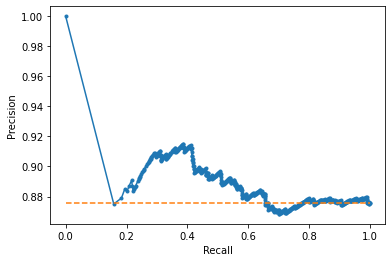

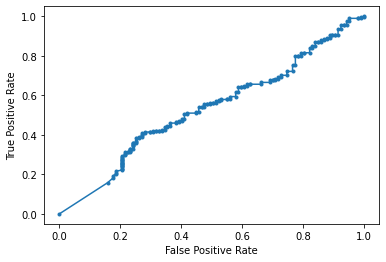

Accuracy: 78.60% Precision: 87.78% Recall: 87.78%
F1: 87.78% MCC: 0.0180
AUPRC: 89.47% AUROC: 53.24%
 accuracy [78.6046511627907]
 precision [87.78220451527224]
 recall [87.78220451527224]
 F1 [87.78220451527224]
 MCC [0.01800896104057291]
 AUPRC [89.47123602354903]
 AUROC [53.24372292760423]
2023-03-20 23:02:17.297982

Training # 2 5
2023-03-20 23:02:17.299790
2023-03-20 23:02:17.299849
Discriminator ZERO -1
FIT
2023-03-20 23:02:18.518542


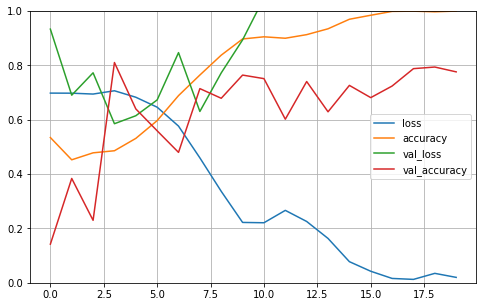


2023-03-20 23:04:41.917126

Testing # 2 5
2023-03-20 23:04:41.917221
2023-03-20 23:04:41.917257
PREDICT
2023-03-20 23:04:42.126620
Test 1:0 724:120 85.78%
Predict 1:0 743:101 88.03%
Test sizes (844, 4997) (844,)
Range of scores: 3.9131005e-06 to 1.0
Score threshold 0.5
Confusion matrix
 [[ 16 104]
 [ 85 639]]
Normalized matrix
 [[0.01895735 0.12322275]
 [0.1007109  0.757109  ]]


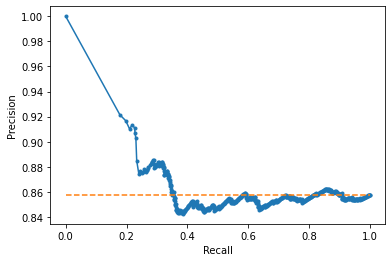

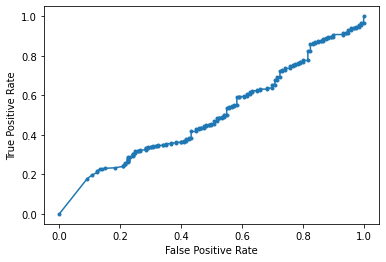

Accuracy: 77.61% Precision: 86.00% Recall: 88.26%
F1: 87.12% MCC: 0.0171
AUPRC: 87.85% AUROC: 50.40%
 accuracy [77.60663507109004]
 precision [86.00269179004037]
 recall [88.25966850828729]
 F1 [87.11656441717791]
 MCC [0.017140405427957014]
 AUPRC [87.85006361286067]
 AUROC [50.40343001841621]
2023-03-20 23:04:43.318664


In [14]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [15]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 75.66% std 3.63
 precision mean 85.94% std 1.03
 recall mean 85.78% std 4.86
 F1 mean 85.79% std 2.56
 MCC mean -0.01% std 0.04
 AUPRC mean 87.97% std 1.23
 AUROC mean 50.46% std 3.02
 accuracy [[75.29691211401425], [68.0327868852459], [71.77322074788903], [75.52204176334106], [79.85865724381625], [78.0630105017503], [73.73380447585394], [78.08716707021792], [78.6046511627907], [77.60663507109004]]
 precision [[85.3185595567867], [86.9767441860465], [85.60606060606061], [84.40366972477065], [86.80465717981889], [85.9395532194481], [84.7645429362881], [85.8108108108108], [87.78220451527224], [86.00269179004037]]
 recall [[85.79387186629526], [74.8], [80.25568181818183], [87.5], [90.67567567567568], [88.9795918367347], [84.41379310344827], [89.31082981715893], [87.78220451527224], [88.25966850828729]]
 F1 [[85.55555555555556], [80.43010752688173], [82.84457478005865], [85.92394929953302], [88.69795109054857], [87.43315508021391], [84.58880442294404], [87.52584424534804], [